### Edgar Moises Hernandez-Gonzalez
#### 02/03/20-25/03/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D + LSTM, CNN-2D + GRU y ConvLSTM2D
##### Caracteristicas = Espectrogramas STFFT (3D)
##### 2 canales C3 y C4
##### Concatenacion vertical
##### 5 ejecuciones independientes

#### CNN-2D + LSTM
##### Sujeto 1
##### Accuracy = 52.08%
##### Kappa = 0.3611

#### CNN-2D + LSTM BN
##### Sujeto 1
##### Accuracy = %
##### Kappa = 0.

#### CNN-2D + GRU
##### Sujeto 1
##### Accuracy = 51.39%
##### Kappa = 0.3519

#### CNN-2D + GRU BN
##### Sujeto 1
##### Accuracy = %
##### Kappa = 0.

#### ConvLSTM2D
##### Sujeto 1
##### Accuracy = 49.65%
##### Kappa = 0.3287

#### ConvLSTM2D BN
##### Sujeto 1
##### Accuracy = %
##### Kappa = 0.

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.signal import spectrogram
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPool2D, Flatten, Dense, Dropout,
                                     TimeDistributed, LSTM, GRU, ConvLSTM2D,
                                     BatchNormalization, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [0]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
c3_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None).iloc[:, 7000:8000]
c4_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None).iloc[:, 11000:12000]
c3_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None).iloc[:, 7000:8000]
c4_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None).iloc[:, 11000:12000]

In [0]:
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01E.csv", header=None)

In [0]:
x_train = np.concatenate((c3_train, c4_train), axis=1)
x_test = np.concatenate((c3_test, c4_test), axis=1)

In [0]:
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)

In [0]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 2000)
(288, 2000)
(288, 1)
(288, 1)


In [0]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [0]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [0]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
#unir 2 canales C3 y C4
def unir_espectrogramas_vertical(data):
  fs = 250
  datos = np.zeros((288,48,4))
  temporal = np.zeros((48,4))
  for i in range(data.shape[0]): #288 muestras
    for j in range(2): #2 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*24:(j+1)*24, :] = Sxx[8:32, :]
    datos[i] = temporal
  return datos

In [0]:
#unir 2 canales C3 y C4
'''
def espectrogramas(data):
  fs = 250
  datos = np.zeros((288,24,8))
  for i in range(data.shape[0]): #288 muestras
    sig = data.iloc[i, 7000:8000]
    f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
    C3 = Sxx[8:32, :]
    sig = data.iloc[i, 11000:12000]
    f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
    C4 = Sxx[8:32, :]
    datos[i] = np.concatenate((C3, C4), axis=1)
  return datos
'''

'\ndef espectrogramas(data):\n  fs = 250\n  datos = np.zeros((288,24,8))\n  for i in range(data.shape[0]): #288 muestras\n    sig = data.iloc[i, 7000:8000]\n    f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT\n    C3 = Sxx[8:32, :]\n    sig = data.iloc[i, 11000:12000]\n    f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT\n    C4 = Sxx[8:32, :]\n    datos[i] = np.concatenate((C3, C4), axis=1)\n  return datos\n'

In [0]:
#llamar a unir_espectrogramas_vertical(data, fs)
x_train = unir_espectrogramas_vertical(x_train)
x_test = unir_espectrogramas_vertical(x_test)

In [0]:
print(x_train.shape)
print(x_test.shape)

(288, 48, 4)
(288, 48, 4)


In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

76.44927548656395
56.146734378722755
1.3045029327757274e-05
3.770593846744206e-06


In [0]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 128.0
x_test /= 128.0

In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

0.59725994
0.43864638
1.0191429e-07
2.9457764e-08


In [0]:
#convertir de 3D a 5D
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(288, 1, 48, 4, 1)
(288, 1, 48, 4, 1)


In [0]:
'''def CNN_2D_LSTM_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(512, (3,3), activation='relu',
                                   padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(512, (3,3), activation='relu',
                                   padding='same')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(512, (3,3), activation='relu',
                                   padding='same')))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32))
  model.add(Dropout(0.2))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-5)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

"def CNN_2D_LSTM_TD():\n  model = Sequential()\n  model.add(TimeDistributed(Conv2D(512, (3,3), activation='relu',\n                                   padding='same'),\n                            input_shape=x_train.shape[1:]))\n  model.add(TimeDistributed(MaxPool2D((2,2))))\n  model.add(TimeDistributed(Conv2D(512, (3,3), activation='relu',\n                                   padding='same')))\n  model.add(TimeDistributed(MaxPool2D((2,2))))\n  model.add(TimeDistributed(Conv2D(512, (3,3), activation='relu',\n                                   padding='same')))\n  model.add(TimeDistributed(Flatten()))\n  model.add(LSTM(32))\n  model.add(Dropout(0.2))\n  model.add(Dense(n_classes, activation='softmax'))\n\n  optimizer = Adam(lr=1e-5)\n  model.compile(optimizer = optimizer,\n                loss = 'sparse_categorical_crossentropy',\n                metrics = ['accuracy'])\n  return model"

In [0]:
'''def CNN_2D_LSTM_TD_BN():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(128, (3,3), padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(128, (3,3), padding='same')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(128, (3,3), padding='same')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32))
  model.add(BatchNormalization()) #la activacion antes de BN porque es tanh
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

In [0]:
'''def CNN_2D_GRU_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu',
                                   padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(Flatten()))
  model.add(GRU(16))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-5)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

In [0]:
'''def CNN_2D_GRU_TD_BN():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(64, (3,3), padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(64, (3,3), padding='same')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(Flatten()))
  model.add(GRU(32))
  model.add(BatchNormalization()) #la activacion antes de BN porque es tanh
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-6)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

In [0]:
def Conv_LSTM_2D():
  model = Sequential()
  model.add(ConvLSTM2D(16, (3,3), activation='relu', padding='same',
                       input_shape=x_train.shape[1:]))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(4, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [0]:
'''def Conv_LSTM_2D_BN():
  model = Sequential()
  model.add(ConvLSTM2D(32, (3,3), padding='same',
                       input_shape=x_train.shape[1:]))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Flatten())
  model.add(Dense(16))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-6)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

Iteration: 1
288/288 - 0s - loss: 1.1052 - acc: 0.4965
kappa:  0.3287037037037037
f1: 0.4673415694349119
confusion matrix:
 [[11 45 13  3]
 [ 2 56 13  1]
 [ 6  7 35 24]
 [ 3  6 22 41]]


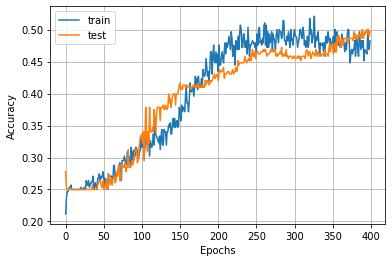

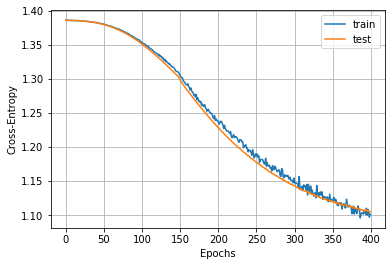

Iteration: 2
288/288 - 0s - loss: 1.0875 - acc: 0.4792
kappa:  0.3055555555555556
f1: 0.46493429246413664
confusion matrix:
 [[45 12 12  3]
 [43 16 10  3]
 [ 3  9 32 28]
 [ 3  4 20 45]]


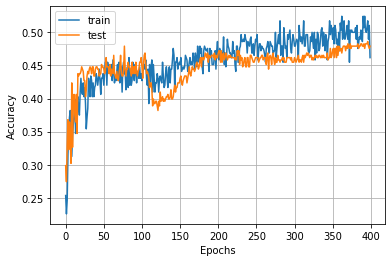

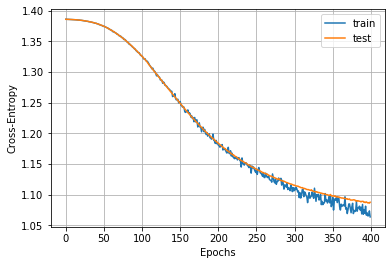


Resultados:
loss: [1.1051620774798923, 1.0875135395261977]
accuracy: [0.4965278, 0.47916666]
kappa: [0.3287037037037037, 0.3055555555555556]
f1: [0.4673415694349119, 0.46493429246413664]


In [0]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(2):
  print("Iteration:", i+1)
    
  #model = CNN_2D_LSTM_TD()
  #model = CNN_2D_LSTM_TD_BN()
  #model = CNN_2D_GRU_TD()
  #model = CNN_2D_GRU_TD_BN()
  model = Conv_LSTM_2D()
  #model = Conv_LSTM_2D_BN()

  history = model.fit(x_train, y_train, epochs=400, batch_size=18,
                      validation_data=(x_test, y_test), verbose=0)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
  array_loss.append(test_loss)
  array_acc.append(test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [0]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_7 (ConvLSTM2D)  (None, 48, 4, 16)         9856      
_________________________________________________________________
dropout_7 (Dropout)          (None, 48, 4, 16)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 12292     
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 20        
Total params: 22,168
Trainable params: 22,168
Non-trainable params: 0
_________________________________________________________________


In [0]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.4878
std: (+/- 0.0087)
Mean Kappa: 0.3171
std: (+/- 0.0116)
Mean F1: 0.4661
Max Accuracy: 0.4965
Max Kappa: 0.3287
Max F1: 0.4673
